In [34]:
import os
import sys
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import cv2 
import math
import random
from math import log
from google.colab.patches import cv2_imshow
from tqdm import tqdm
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['log', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [35]:
def initialize_K_centroids(X, K):
    """ Choose K points from X at random """
    m = len(X)
    return X[np.random.choice(m, K, replace=False), :]

In [36]:
def find_closest_centroids(X, centroids):
    m = len(X)
    c = np.zeros(m)
    for i in range(m):
        # Find distances
        distances = np.linalg.norm(X[i] - centroids, axis=1)

        # Assign closest cluster to c[i]
        c[i] = np.argmin(distances)

    return c

In [37]:
def compute_means(X, idx, K):
    _, n = X.shape
    centroids = np.zeros((K, n))
    for k in range(K):
        examples = X[np.where(idx == k)]
        mean = [np.mean(column) for column in examples.T]
        centroids[k] = mean
    return centroids

In [38]:
def find_k_means(X, K, max_iters=10):
    centroids = initialize_K_centroids(X, K)
    previous_centroids = centroids
    for _ in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_means(X, idx, K)
        if (centroids == previous_centroids).all():
            # The centroids aren't moving anymore.
            return centroids
        else:
            previous_centroids = centroids

    return centroids, idx

In [39]:
try:
    image_path = "/content/drive/MyDrive/Major/images/Lenna.png"
    assert os.path.isfile(image_path)
except (IndexError, AssertionError):
    print('Please specify an image')

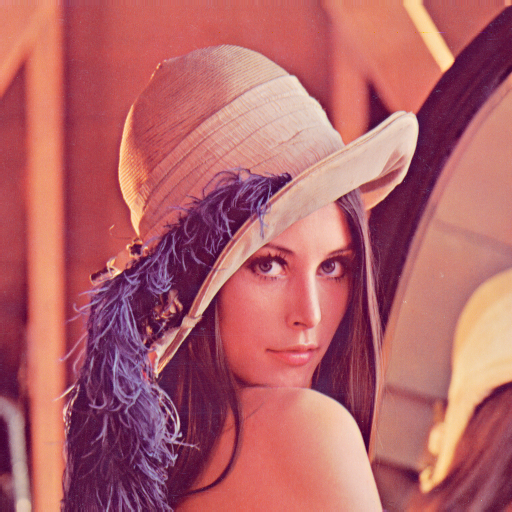

In [40]:
original_img = Image.open(image_path)
original_img

In [41]:
def load_image(path):
    """ Load image from path. Return a numpy array """
    image = original_img
    return np.asarray(image) / 255

In [42]:
image = load_image(original_img)
w, h, d = image.shape
print('Image found with width: {}, height: {}, depth: {}'.format(w, h, d))

Image found with width: 512, height: 512, depth: 3


In [43]:
X = image.reshape((w * h, d))
K = 20 # the desired number of colors in the compressed image

In [44]:
colors, _ = find_k_means(X, K, max_iters=20)

In [45]:
idx = find_closest_centroids(X, colors)

In [46]:
idx = np.array(idx, dtype=np.uint8)
X_reconstructed = np.array(colors[idx, :] * 255, dtype=np.uint8).reshape((w, h, d))
compressed_image = Image.fromarray(X_reconstructed)

In [47]:
compressed_image.save('out.png')

In [48]:
oi = image_path
ci = "out.png"

In [49]:
ogimg = BytesIO()
original_img.save(ogimg, "png")
crimg = BytesIO()
compressed_image.save(crimg, "png")

os = ogimg.tell()
cs = crimg.tell()
cr = os/cs

In [50]:
print(os, cs, cr)

479778 128000 3.748265625


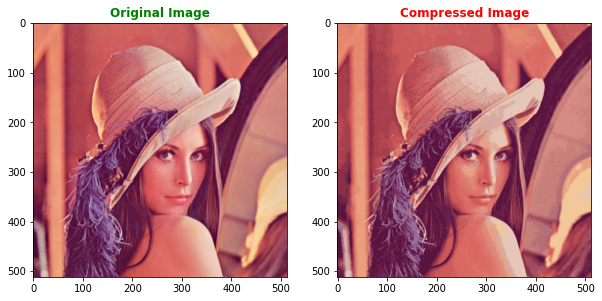

original image size
479778

compressed image size
128000

compression ratio
3.748265625


In [51]:
fig=plt.figure(figsize=(10, 10))

img = mpimg.imread(oi)
fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image", color='green', fontweight="bold")

img = mpimg.imread(ci)
fig.add_subplot(1, 2, 2)
plt.imshow(img)
plt.title("Compressed Image", color='red', fontweight="bold")
plt.show()

print("original image size")
print(os) 
print("\ncompressed image size")
print(cs)
print("\ncompression ratio")
print(cr)

In [52]:
im = Image.open(ci)

In [53]:
def getImageMatrix(imageName):
    im = Image.open(imageName) 
    pix = im.load()
    color = 1
    if type(pix[0,0]) == int:
      color = 0
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix,image_size[0],color

In [54]:
def getImageMatrix_gray(imageName):
    im = Image.open(imageName).convert('LA')
    pix = im.load()
    image_size = im.size 
    image_matrix = []
    for width in range(int(image_size[0])):
        row = []
        for height in range(int(image_size[1])):
                row.append((pix[width,height]))
        image_matrix.append(row)
    return image_matrix,image_size[0]

In [55]:
def ArnoldCatTransform(img, num):
    rows, cols, ch = img.shape
    n = rows
    img_arnold = np.zeros([rows, cols, ch])
    for x in range(0, rows):
        for y in range(0, cols):
            img_arnold[x][y] = img[(x+y)%n][(x+2*y)%n]  
    return img_arnold    

In [56]:
def ArnoldCatEncryption(imageName, key):
    img = cv2.imread(imageName)
    for i in range (0,key):
        img = ArnoldCatTransform(img, i)
    cv2.imwrite(imageName.split('.')[0] + "_ArnoldcatEnc.png", img)
    cv2.imwrite("/content/drive/MyDrive/Major/images/encrypted/lenna_kmeans_arnoldcat_encrypt.png", img)
    cv2.waitKey(0)
    return img

In [57]:
def ArnoldCatDecryption(imageName, key):
    img = cv2.imread(imageName)
    rows, cols, ch = img.shape
    dimension = rows
    decrypt_it = dimension
    if (dimension%2==0) and 5**int(round(log(dimension/2,5))) == int(dimension/2):
        decrypt_it = 3*dimension
    elif 5**int(round(log(dimension,5))) == int(dimension):
        decrypt_it = 2*dimension
    elif (dimension%6==0) and  5**int(round(log(dimension/6,5))) == int(dimension/6):
        decrypt_it = 2*dimension
    else:
        decrypt_it = int(12*dimension/7)
    for i in range(key,decrypt_it):
        img = ArnoldCatTransform(img, i)
    cv2.imwrite(imageName.split('_')[0] + "_ArnoldcatDec.png",img)
    return img

In [58]:
image = "out"
ext = ".png"
key = 20

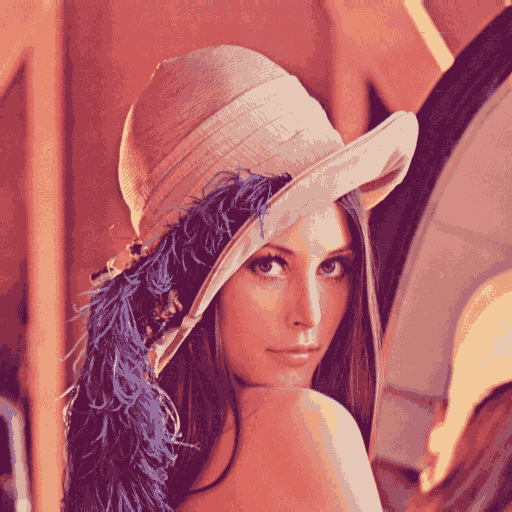

In [59]:
img = cv2.imread(image + ext)
cv2_imshow(img)

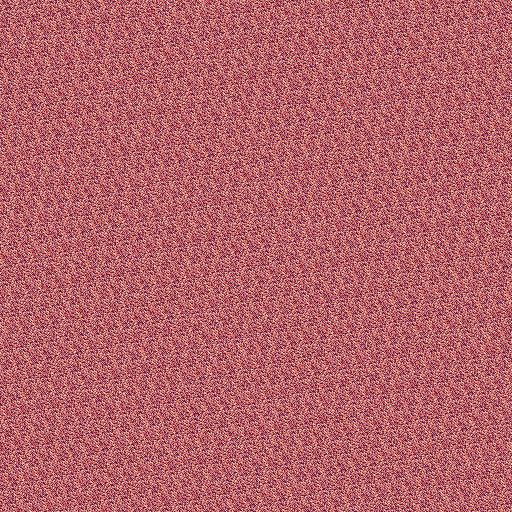

In [60]:
ArnoldCatEncryptionIm = ArnoldCatEncryption(image + ext, key)
cv2_imshow(ArnoldCatEncryptionIm)

In [61]:
ei="/content/out_ArnoldcatEnc.png"

In [62]:
# ArnoldCatDecryptionIm = ArnoldCatDecryption(image + "_ArnoldcatEnc.png", key)
# cv2_imshow(ArnoldCatDecryptionIm)

In [63]:
# Same as NPCR both are used for sensitivity analysis two encrypted image is required



# loc1="/content/drive/MyDrive/images/encrypted/imagedecrypt.png"
# loc2="/content/drive/MyDrive/images/Lenna.png"
uloc1 = ei
uloc2 = oi
def uaci(loc1,loc2):
    image1 = Image.open(loc1)
    image2 = Image.open(loc2)
    pixel1=image1.load()
    pixel2=image2.load()
    width,height=image1.size
    value=0.0
    for y in range(0,height):
        for x in range(0,width):
            value=(abs(pixel1[x,y][0]-pixel2[x,y][0])/255)+value

    value=(value/(width*height))*100
    return value
print("UACI")
print(uaci(uloc1,uloc2))

#decrypted image and original image

UACI
21.18311713725486


In [64]:
  # It has a NPCR(Number of pixel changed rate).It compares the pixel values of the original image and the encrypted image.
  # The resultant value is returned in percentage.If the value is more than 99% then the analysis is positive.
    
   # It consist of three modules rateofchange(),sumofpixel(),npcrv().


 #   This method compares two image.If the pixel value is same then 0 is stored in the matrix else one is stored
# loc1="/content/drive/MyDrive/images/encrypted/imagedecrypt.png"
# loc2="/content/drive/MyDrive/images/Lenna.png"
loc1 = ei
loc2 = oi
def rateofchange(height,width,pixel1,pixel2,matrix,i):

    for y in range(0,height):
        for x in range(0,width):
            #print(x,y)
            if pixel1[x,y][i] == pixel2[x,y][i]:
                matrix[x,y]=0
            else:
                matrix[x,y]=1
    return matrix
"""
    sum of the values of 1 stored in matrix is calculated
"""
def sumofpixel(height,width,pixel1,pixel2,ematrix,i):
    matrix=rateofchange(height,width,pixel1,pixel2,ematrix,i)
    psum=0
    for y in range(0,height):
        for x in range(0,width):
            psum=matrix[x,y]+psum
    return psum

"""
Finally the above two module is called to calculate the values
"""
def npcrv(loc1,loc2):
    c1 = Image.open(loc1)
    c2 = Image.open(loc2)
    width, height = c1.size
    pixel1 = c1.load()
    pixel2 = c2.load()
    ematrix = np.empty([width, height])
    per=(((sumofpixel(height,width,pixel1,pixel2,ematrix,0)/(height*width))*100)+((sumofpixel(height,width,pixel1,pixel2,ematrix,1)/(height*width))*100)+((sumofpixel(height,width,pixel1,pixel2,ematrix,2)/(height*width))*100))/3
    return per
print("NPCR")
print(npcrv(loc1,loc2))

NPCR
99.26109313964844


In [65]:
#calculating size of encrypted and decrypted files
encrypted_img = Image.open(ei)
decrypted_img = Image.open(ci)
enimg = BytesIO()
encrypted_img.save(enimg, "png")
deimg = BytesIO()
decrypted_img.save(deimg, "png")
es = enimg.tell()
ds = deimg.tell()

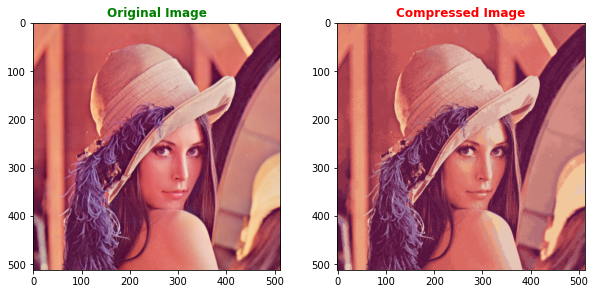

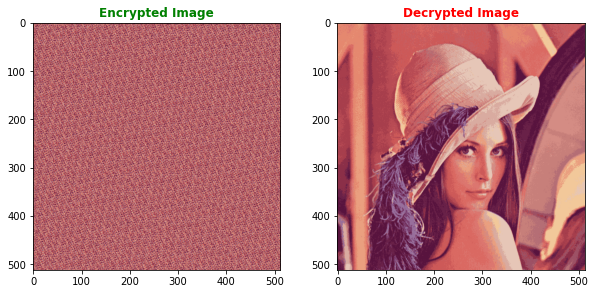

original image size
479778

compressed image size
128000

encrypted image size
358522

decrypted image size
128000

compression ratio
3.748265625

UACI
21.18311713725486

NPCR
99.26109313964844


In [66]:
fig=plt.figure(figsize=(10, 10))

img = mpimg.imread(oi)
fig.add_subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image", color='green', fontweight="bold")

img = mpimg.imread(ci)
fig.add_subplot(2, 2, 2)
plt.imshow(img)
plt.title("Compressed Image", color='red', fontweight="bold")
plt.show()

fig=plt.figure(figsize=(10, 10))

img = mpimg.imread(ei)
fig.add_subplot(2, 2, 3)
plt.imshow(img)
plt.title("Encrypted Image", color='green', fontweight="bold")

img = mpimg.imread(ci)
fig.add_subplot(2, 2, 4)
plt.imshow(img)
plt.title("Decrypted Image", color='red', fontweight="bold")
plt.show()

print("original image size")
print(os) 
print("\ncompressed image size")
print(cs)
print("\nencrypted image size")
print(es) 
print("\ndecrypted image size")
print(ds)
print("\ncompression ratio")
print(cr)
print("\nUACI")
print(uaci(uloc1,uloc2))
print("\nNPCR")
print(npcrv(loc1,loc2))